In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction import text 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import shapiro

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
df = pd.read_csv('../data/combined_df.csv')

In [3]:
df.head()

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x,1,11,65,114,674,0,0
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind,1,8,48,231,1515,0,0
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50,1,9,46,60,320,0,0
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160,1,21,114,0,0,0,0
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers,1,20,139,0,0,0,0


In [4]:
class StemLemmatizeTransformer(BaseEstimator, TransformerMixin):
    '''Class that 
    1. extract words from url
    2. stem words
    3. lemmatize words
    '''
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        stemmed_lemmatized_text = []
        replace_list = ['apps.', 'http://', 'https://', 'www.', '.net', '.com', '/', '.', '-']
        for i, text in enumerate(X):
            for part in replace_list:
                text = text.replace(part, ' ')
            # X[i] = text
            stemmed_words = [self.stemmer.stem(word) for word in text.split()]
            stemmed_lemmatized_text.append(' '.join([self.lemmatizer.lemmatize(word) for word in stemmed_words]))
        return stemmed_lemmatized_text


In [5]:

pipeline = Pipeline([
    ('stem_lemmatize', StemLemmatizeTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])


In [6]:
model = pipeline.fit(df['title'], df['label'])

In [7]:
df['pred'] = model.predict(df['title'])

In [8]:
def print_confusion_matrix(y_actual, y_pred):
    cf_matrix = confusion_matrix(y_actual, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

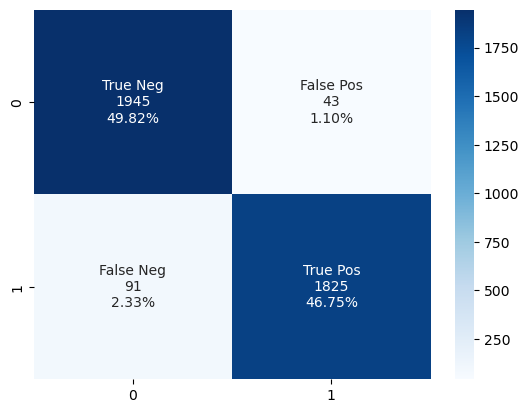

In [9]:
print_confusion_matrix(df['label'],df['pred'])

In [6]:

class StemLemmaTfidfLDA(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words='english', max_features=5000, n_components=10, max_df=0.95, min_df=2):
        self.stemmer = SnowballStemmer('english')
        self.lemmatizer = WordNetLemmatizer()
        self.tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
        self.lda_model = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
        self.max_df = max_df
        self.min_df = min_df
    
    def stem_and_lemmatize(self, document):
        return [self.stemmer.stem(self.lemmatizer.lemmatize(token)) for token in document.split()]

    def fit(self, X, y=None):
        X_stemmed_lemmatized = [' '.join(self.stem_and_lemmatize(document)) for document in X]
        X_tfidf = self.tfidf_vectorizer.fit_transform(X_stemmed_lemmatized)
        self.lda_model.fit(X_tfidf)
        return self

    def transform(self, X):
        X_stemmed_lemmatized = [' '.join(self.stem_and_lemmatize(document)) for document in X]
        X_tfidf = self.tfidf_vectorizer.transform(X_stemmed_lemmatized)
        X_lda = self.lda_model.transform(X_tfidf)
        return X_lda


In [23]:
def metrics_for_model(y_true, y_pred):
    '''find the relavent metrics from confusion metrics
    arg:
        y_true: true value for y
        y_pred: predicted value for y
    out:
        pre: precison score
        rec: recall score
        f1: f1 socre
    '''
    tn, fp, fn, tp =confusion_matrix(y_true, y_pred).ravel()
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*(pre*rec)/(pre+rec)
    print(f"The recall of this inference is: {rec}")
    print(f"The precision of this inference is: {pre}")
    print(f"The f1 score for this inference is: {f1}")
    return pre, rec, f1

In [24]:
metrics_for_model(df['label'], df['pred']);

The recall of this inference is: 0.9525052192066806
The precision of this inference is: 0.9769807280513919
The f1 score for this inference is: 0.9645877378435519


In [ ]:
# dnn based idea generator that make weak links.
# then use GAN to determine if the idea is feasible.